In [1]:
import os
import cv2
import gc
import torch
import optuna
import datetime
import numpy as np
from tqdm import tqdm
from pathlib import Path
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import pandas as pd
import pickle
import io
import lmdb  
import logging
import sqlite3
from optuna.pruners import MedianPruner
from torch.utils.data import DataLoader
from torch.amp import GradScaler, autocast
import matplotlib.pyplot as plt
import timm  
import seaborn as sns
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import display as ipython_display

logging.basicConfig(level=logging.INFO)

# ------------------------------
# CONSTANTS & HYPERPARAMETERS
# ------------------------------
GRADIENT_ACCUM_STEPS = 2        # Changed from 4 to 2 for optimal VRAM usage
NUM_FRAMES = 50
# Progressive resolution schedule: (resolution, epochs)
PROG_SCHEDULE = [(112, 6), (224, 8), (300, 6)]  # Modified schedule
BATCH_SIZES = {
    112: 8,  # Higher batch size for low resolution
    224: 6,  # Medium batch size
    300: 4   # Lower batch size for high resolution
}
FOCAL_ALPHA = 0.25
FOCAL_GAMMA = 2.0

# ------------------------------
# Environment & Paths
# ------------------------------
BASE_DIR = Path("C:/Users/abhis/Downloads/Documents/Learner Engagement Project")
DATA_DIR = BASE_DIR / "data" / "DAiSEE"
FRAMES_DIR = DATA_DIR / "ExtractedFrames"
LABELS_DIR = DATA_DIR / "Labels"
MODEL_DIR = BASE_DIR / "models"
MODEL_DIR.mkdir(parents=True, exist_ok=True)
CACHE_DIR = BASE_DIR / "cache"
CACHE_DIR.mkdir(exist_ok=True)

print("Models directory exists:", os.path.exists(MODEL_DIR))
print("Checkpoint path writable:", os.access(MODEL_DIR, os.W_OK))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ------------------------------
# Image Transformations
# ------------------------------
def get_transform(resolution):
    return transforms.Compose([
        transforms.Resize((resolution, resolution)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])


Models directory exists: True
Checkpoint path writable: True
Using device: cuda


In [2]:
# ------------------------------
# Utility Functions
# ------------------------------
def get_csv_clip_id(video_stem: str) -> str:
    base = video_stem.strip()
    return base.replace("110001", "202614", 1) if base.startswith("110001") else base

def select_impactful_frames(video_folder: Path, num_frames=50):
    frame_files = sorted(video_folder.glob("frame_*.jpg"))
    total = len(frame_files)
    if total == 0:
        return []
    if total <= num_frames:
        return frame_files
    indices = np.linspace(0, total - 1, num_frames, dtype=int)
    return [frame_files[i] for i in indices]

# ------------------------------
# Precomputation & Caching Functions
# ------------------------------
def precompute_best_frames(csv_file: Path, video_root: Path, num_frames=50, resolution=224):
    data = pd.read_csv(csv_file, dtype=str)
    data.columns = data.columns.str.strip()
    split = csv_file.stem.replace("Labels", "").strip()
    valid_indices = []
    precomputed = []
    skipped = 0
    for idx, row in tqdm(data.iterrows(), total=len(data),
                         desc=f"Precomputing frames for {csv_file.stem} at {resolution}x{resolution}"):
        clip_id = get_csv_clip_id(row["ClipID"].split('.')[0])
        video_folder = video_root / split / clip_id
        if video_folder.exists():
            frames = select_impactful_frames(video_folder, num_frames)
            if len(frames) >= num_frames:
                precomputed.append(frames[:num_frames])
                valid_indices.append(idx)
            else:
                skipped += 1
        else:
            skipped += 1
    print(f"Precomputation: Skipped {skipped} videos out of {len(data)}.")
    cache_data = {"valid_indices": valid_indices, "precomputed_frames": precomputed}
    cache_file = CACHE_DIR / f"precomputed_{csv_file.stem}_frame_{num_frames}_{resolution}.pkl"
    with open(cache_file, "wb") as f:
        pickle.dump(cache_data, f)
    print(f"Precomputed results saved to {cache_file}")
    return cache_data

def convert_pkl_to_lmdb(csv_file: Path, num_frames=50, resolution=224,
                          transform=None, lmdb_map_size=1 * 1024**3):
    if transform is None:
        transform = get_transform(resolution)
    pkl_file = CACHE_DIR / f"precomputed_{csv_file.stem}_frame_{num_frames}_{resolution}.pkl"
    lmdb_path = CACHE_DIR / f"lmdb_{csv_file.stem}_frame_{num_frames}_{resolution}"
    # If LMDB already exists, return it.
    if (lmdb_path / "data.mdb").exists():
        print(f"LMDB database already exists at {lmdb_path}")
        return lmdb_path

    env = lmdb.open(str(lmdb_path), map_size=lmdb_map_size)
    if not pkl_file.exists():
        precompute_best_frames(csv_file, FRAMES_DIR, num_frames=num_frames, resolution=resolution)
    with open(pkl_file, "rb") as f:
        cache = pickle.load(f)
    valid_indices = cache["valid_indices"]
    file_paths_list = cache["precomputed_frames"]

    # Use EfficientNetV2-L (tf variant) from timm with frozen backbone
    backbone = timm.create_model("tf_efficientnetv2_l", pretrained=True)
    backbone.reset_classifier(0)
    backbone.eval()
    backbone.to(device)
    for param in backbone.parameters():
        param.requires_grad = False

    print(f"Converting frame paths to LMDB features for {csv_file.stem} at {resolution}x{resolution} ...")
    with env.begin(write=True) as txn:
        for idx, paths in tqdm(enumerate(file_paths_list), total=len(file_paths_list)):
            video_features = []
            for fp in paths:
                try:
                    img = Image.open(fp).convert("RGB")
                except Exception:
                    img = Image.new('RGB', (resolution, resolution))
                tensor = transform(img).unsqueeze(0).to(device)
                with torch.no_grad(), autocast(device_type='cuda', dtype=torch.float16):
                    feat = backbone(tensor)
                    feat = feat.squeeze(0).cpu().half().detach()  # ensure detached and on CPU
                # Convert to NumPy array to avoid pickling issues with torch tensors
                video_features.append(feat.numpy())
            if video_features:
                video_features_np = np.stack(video_features)  # shape: (num_frames, feature_dim)
                key = f"video_{valid_indices[idx]}".encode("utf-8")
                txn.put(key, pickle.dumps(video_features_np))
    env.close()
    print(f"LMDB database created at {lmdb_path}")
    return lmdb_path

# ------------------------------
# LMDB Dataset Classes
# ------------------------------
class VideoDatasetLMDB(torch.utils.data.Dataset):
    def __init__(self, csv_file, lmdb_path, num_frames=50, resolution=224):
        self.data = pd.read_csv(csv_file, dtype=str)
        self.data.columns = self.data.columns.str.strip()
        self.resolution = resolution
        pkl_file = CACHE_DIR / f"precomputed_{csv_file.stem}_frame_{num_frames}_{resolution}.pkl"
        with open(pkl_file, "rb") as f:
            cache = pickle.load(f)
        self.valid_indices = cache["valid_indices"]
        self.data = self.data.iloc[self.valid_indices].reset_index(drop=True)
        self.num_frames = num_frames
        self.lmdb_path = str(lmdb_path)
        self.env = None

    def _init_env(self):
        if self.env is None:
            self.env = lmdb.open(self.lmdb_path, readonly=True, lock=False, readahead=False, meminit=False)
        return self.env

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        env = self._init_env()
        original_idx = self.valid_indices[idx]
        key = f"video_{original_idx}".encode("utf-8")
        with env.begin(write=False) as txn:
            data_bytes = txn.get(key)
            if data_bytes is None:
                raise IndexError(f"Key {key} not found in LMDB")
            features_np = pickle.loads(data_bytes)
            features = torch.from_numpy(features_np)
        labels = self.data.iloc[idx][["Engagement", "Boredom", "Confusion", "Frustration"]].astype(int)
        return features, torch.tensor(labels.values, dtype=torch.long)

class VideoDatasetRaw(torch.utils.data.Dataset):
    def __init__(self, csv_file, video_root, num_frames=50, transform=None):
        self.data = pd.read_csv(csv_file, dtype=str)
        self.data.columns = self.data.columns.str.strip()
        pkl_file = CACHE_DIR / f"precomputed_{csv_file.stem}_frame_{num_frames}_raw.pkl"
        if not pkl_file.exists():
            cache = precompute_best_frames(csv_file, video_root, num_frames=num_frames)
            with open(pkl_file, "wb") as f:
                pickle.dump(cache, f)
        else:
            with open(pkl_file, "rb") as f:
                cache = pickle.load(f)
        self.valid_indices = cache["valid_indices"]
        self.file_paths = cache["precomputed_frames"]
        self.data = self.data.iloc[self.valid_indices].reset_index(drop=True)
        self.num_frames = num_frames
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        paths = self.file_paths[idx]
        frames = []
        for fp in paths:
            try:
                img = Image.open(fp).convert("RGB")
            except Exception:
                img = Image.new('RGB', (self.transform.transforms[0].size, self.transform.transforms[0].size))
            if self.transform:
                img = self.transform(img)
            frames.append(img)
        video_tensor = torch.stack(frames)  # (T, C, H, W)
        labels = self.data.iloc[idx][["Engagement", "Boredom", "Confusion", "Frustration"]].astype(int)
        return video_tensor, torch.tensor(labels.values, dtype=torch.long)

# ------------------------------
# Focal Loss Implementation
# ------------------------------
class FocalLoss(nn.Module):
    def __init__(self, alpha=FOCAL_ALPHA, gamma=FOCAL_GAMMA, reduction="mean"):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ce = nn.CrossEntropyLoss(reduction="none")
    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        pt = torch.exp(-ce_loss)
        loss = self.alpha * ((1 - pt) ** self.gamma) * ce_loss
        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        else:
            return loss

# ------------------------------
# CBAM Module (Spatial-Only)
# ------------------------------
class CBAM(nn.Module):
    def __init__(self, channels, kernel_size=7):
        super(CBAM, self).__init__()
        # Remove channel attention, keep only spatial attention
        self.spatial_attention = nn.Sequential(
            nn.Conv1d(2, 1, kernel_size=kernel_size, padding=kernel_size // 2, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        # x: (B, C, T)
        # Apply spatial attention only - no channel attention
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        spatial_attn = self.spatial_attention(torch.cat([avg_out, max_out], dim=1))
        return x * spatial_attn
    
class CrossAttention(nn.Module):
    def __init__(self, feature_dim):
        super(CrossAttention, self).__init__()
        self.query = nn.Linear(feature_dim, feature_dim)
        self.key = nn.Linear(feature_dim, feature_dim)
        self.value = nn.Linear(feature_dim, feature_dim)
        self.softmax = nn.Softmax(dim=-1)
    def forward(self, spatial_feat, temporal_feat):
        # spatial_feat: (B, feature_dim)
        # temporal_feat: (B, feature_dim)
        query = self.query(spatial_feat).unsqueeze(1)  # (B, 1, feature_dim)
        key = self.key(temporal_feat).unsqueeze(2)       # (B, feature_dim, 1)
        attn = self.softmax(torch.bmm(query, key))       # (B, 1, 1)
        value = self.value(temporal_feat)
        return attn.squeeze(-1) * value  # (B, feature_dim)


# ------------------------------
# Model Architecture
# ------------------------------
class EfficientNetV2L_BiLSTM_CrossAttn_CBAM(nn.Module):
    def __init__(self, lstm_hidden=256, lstm_layers=2, dropout_rate=0.5, classifier_hidden=256):
        super(EfficientNetV2L_BiLSTM_CrossAttn_CBAM, self).__init__()
        self.backbone = timm.create_model("tf_efficientnetv2_l", pretrained=True)
        self.backbone.reset_classifier(0)
        # Freeze early layers (up to block index 5)
        if hasattr(self.backbone, "blocks"):
            for i, block in enumerate(self.backbone.blocks):
                if i < 6:
                    for param in block.parameters():
                        param.requires_grad = False
        # Dynamically set feature dimension based on the backbone
        if hasattr(self.backbone, "num_features"):
            self.feature_dim = self.backbone.num_features
        else:
            self.feature_dim = 1536  # fallback if attribute not present
        
        # Spatial-only CBAM
        self.cbam = CBAM(self.feature_dim, kernel_size=7)
        
        # 2-layer BiLSTM with dropout
        self.bilstm = nn.LSTM(
            input_size=self.feature_dim, 
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,  # Changed from 1 to 2
            batch_first=True, 
            bidirectional=True,
            dropout=0.3  # Added dropout between layers
        )
        
        self.spatial_proj = nn.Linear(self.feature_dim, classifier_hidden)
        self.temporal_proj = nn.Linear(2 * lstm_hidden, classifier_hidden)
        self.cross_attn = CrossAttention(classifier_hidden)
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(classifier_hidden * 2, 16)  # 16 outputs (reshaped to 4x4)

    def forward(self, x):
        # Support both raw image inputs (B, T, C, H, W) and precomputed features (B, T, feature_dim)
        if x.dim() == 5:
            # Raw images: (B, T, C, H, W)
            B, T, C, H, W = x.size()
            x = x.view(-1, C, H, W)  # (B*T, C, H, W)
            features = self.backbone(x)  # (B*T, feature_dim)
            features = features.view(B, T, self.feature_dim)  # (B, T, feature_dim)
        elif x.dim() == 3:
            # Precomputed features: (B, T, feature_dim)
            features = x
            B, T, _ = features.size()
        else:
            raise ValueError("Input tensor must have 3 or 5 dimensions.")
            
        # Apply CBAM: convert to (B, feature_dim, T)
        features = features.permute(0, 2, 1)
        features = self.cbam(features)
        features = features.permute(0, 2, 1)  # back to (B, T, feature_dim)
        
        # Process temporal information with BiLSTM
        lstm_out, (h_n, _) = self.bilstm(features)
        
        # Combine final hidden states with mean pooling
        final_hidden = torch.cat((h_n[-2], h_n[-1]), dim=1)  # Last layer, both directions
        mean_pooled = torch.mean(lstm_out, dim=1)  # Mean across time dimension
        temporal_context = final_hidden + 0.3 * mean_pooled  # Weighted combination
        
        # Spatial features
        spatial_feature = features.mean(dim=1)  # (B, feature_dim)
        
        spatial_proj = self.spatial_proj(spatial_feature)  # (B, classifier_hidden)
        temporal_proj = self.temporal_proj(temporal_context)  # (B, classifier_hidden)
        cross_context = self.cross_attn(spatial_proj, temporal_proj)  # (B, classifier_hidden)
        
        fusion = torch.cat((spatial_proj, cross_context), dim=1)  # (B, 2*classifier_hidden)
        fusion = self.dropout(fusion)
        logits = self.classifier(fusion)  # (B, 16)
        
        return logits.view(B, 4, 4)

# ------------------------------
# Training Function with Progressive Resolution, Mixed Precision & Gradient Accumulation
# ------------------------------
def progressive_train_model(model, total_epochs, lr, checkpoint_path, batch_size,
                            patience=5, gradient_accum_steps=GRADIENT_ACCUM_STEPS):
    # Set parameters for AdamW optimizer
    backbone_params = list(model.backbone.parameters())
    backbone_param_ids = {id(p) for p in backbone_params}
    other_params = [p for p in model.parameters() if id(p) not in backbone_param_ids]
    
    optimizer = optim.AdamW([
        {"params": backbone_params, "lr": lr * 0.1},  # Lower LR for backbone
        {"params": other_params, "lr": lr}
    ], weight_decay=1e-4)
    
    # Calculate total epochs for cosine annealing
    total_steps = sum(ep * (len(pd.read_csv(train_csv)) // BATCH_SIZES[res] + 1) 
                      for res, ep in PROG_SCHEDULE)
    
    # Cosine annealing scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer, 
        T_max=total_steps // gradient_accum_steps,
        eta_min=1e-6
    )
    
    scaler = GradScaler()
    focal_loss = FocalLoss(alpha=FOCAL_ALPHA, gamma=FOCAL_GAMMA).to(device)
    best_val_loss = float('inf')
    early_stop_counter = 0
    checkpoint_path.parent.mkdir(parents=True, exist_ok=True)
    
    current_epoch = 0
    for res_idx, (resolution, epochs) in enumerate(PROG_SCHEDULE):
        # Update batch size based on resolution
        current_batch_size = BATCH_SIZES[resolution]
        
        print(f"\nTraining at resolution {resolution}px for {epochs} epochs")
        print(f"Batch size: {current_batch_size}, Gradient accumulation: {gradient_accum_steps}x")
        
        # Freezing strategy based on resolution stage
        if res_idx == 0:  # First resolution (112px)
            # Freeze backbone except final layers
            for i, layer in enumerate(model.backbone.blocks):
                for param in layer.parameters():
                    param.requires_grad = (i >= 6)
                    
        elif res_idx == 1:  # Second resolution (224px)
            # Unfreeze more backbone layers
            for param in model.backbone.parameters():
                param.requires_grad = True
                
        # At highest resolution, everything is already unfrozen
        
        # Setup data for current resolution
        transform = get_transform(resolution)
        train_lmdb = convert_pkl_to_lmdb(train_csv, num_frames=NUM_FRAMES, resolution=resolution,
                                          transform=transform, lmdb_map_size=1 * 1024**3)
        val_lmdb = convert_pkl_to_lmdb(val_csv, num_frames=NUM_FRAMES, resolution=resolution,
                                        transform=transform, lmdb_map_size=1 * 1024**3)
        train_set = VideoDatasetLMDB(train_csv, train_lmdb, num_frames=NUM_FRAMES, resolution=resolution)
        val_set = VideoDatasetLMDB(val_csv, val_lmdb, num_frames=NUM_FRAMES, resolution=resolution)
        
        train_loader = DataLoader(train_set, batch_size=current_batch_size, shuffle=True, 
                                  num_workers=2, pin_memory=True)
        val_loader = DataLoader(val_set, batch_size=current_batch_size, shuffle=False, 
                                num_workers=2, pin_memory=True)
        
        for epoch in range(epochs):
            print(f"Progressive Training: Epoch {current_epoch+1}/{total_epochs} at resolution {resolution}x{resolution}")
            model.train()
            running_loss = 0.0
            
            for i, (features, labels) in enumerate(tqdm(train_loader, desc="Training")):
                features = features.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)
                
                with autocast(device_type='cuda', dtype=torch.float16):
                    outputs = model(features)
                    outputs = outputs.view(outputs.size(0), 4, 4)
                    # Compute loss over the 4 outputs
                    loss = sum(focal_loss(outputs[:, d], labels[:, d]) for d in range(4)) / 4.0
                
                # Apply gradient accumulation
                scaler.scale(loss / gradient_accum_steps).backward()
                
                if (i + 1) % gradient_accum_steps == 0:
                    scaler.step(optimizer)
                    scheduler.step()  # Update learning rate
                    scaler.update()
                    optimizer.zero_grad()
                
                running_loss += loss.item() * features.size(0)
                
                # Cleanup to avoid memory issues
                del features, labels, outputs, loss
                if (i + 1) % 30 == 0:
                    torch.cuda.empty_cache()
                    gc.collect()
            
            train_loss = running_loss / len(train_loader.dataset)
            
            # Validation phase
            model.eval()
            val_loss = 0.0
            with torch.no_grad(), autocast(device_type='cuda', dtype=torch.float16):
                for features, labels in val_loader:
                    features = features.to(device, non_blocking=True)
                    labels = labels.to(device, non_blocking=True)
                    outputs = model(features)
                    outputs = outputs.view(outputs.size(0), 4, 4)
                    loss = sum(focal_loss(outputs[:, d], labels[:, d]) for d in range(4)) / 4.0
                    val_loss += loss.item() * features.size(0)
            
            val_loss /= len(val_loader.dataset)
            print(f"Epoch {current_epoch+1}/{total_epochs} at {resolution}x{resolution} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
            
            # Save best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                state = {
                    "epoch": current_epoch + 1,
                    "best_val_loss": best_val_loss,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict()
                }
                temp_path = checkpoint_path.with_suffix(".tmp")
                torch.save(state, temp_path, _use_new_zipfile_serialization=False)
                if checkpoint_path.exists():
                    checkpoint_path.unlink()
                temp_path.rename(checkpoint_path)
                early_stop_counter = 0
                print(f"Model saved to {checkpoint_path}")
            else:
                early_stop_counter += 1
                
            if early_stop_counter >= patience:
                print(f"Early stopping at epoch {current_epoch+1}. Best val loss: {best_val_loss:.4f}")
                return best_val_loss
                
            current_epoch += 1
            
    return best_val_loss

# ------------------------------
# Evaluation Function
# ------------------------------
from sklearn.metrics import classification_report, confusion_matrix
def evaluate_model(model, test_loader):
    """Evaluate model with confidence-based post-processing to prevent class collapse"""
    model.eval()
    emotions = ["Engagement", "Boredom", "Confusion", "Frustration"]
    
    # Store predictions and labels
    all_outputs = {emotion: [] for emotion in emotions}
    all_labels = {emotion: [] for emotion in emotions}
    
    # Forward pass to collect predictions
    with torch.no_grad(), autocast(device_type='cuda', dtype=torch.float16):
        for frames, labels in tqdm(test_loader, desc="Evaluating"):
            frames = frames.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            outputs = model(frames)
            outputs = outputs.view(outputs.size(0), 4, 4)
            
            # Store outputs and labels for each emotion
            for i, emotion in enumerate(emotions):
                all_outputs[emotion].append(outputs[:, i].cpu())
                all_labels[emotion].append(labels[:, i].cpu())
    
    # Process each emotion
    for i, emotion in enumerate(emotions):
        # Concatenate results from all batches
        logits = torch.cat(all_outputs[emotion], dim=0)
        labels = torch.cat(all_labels[emotion], dim=0).numpy()
        
        # Apply softmax to get probabilities
        probs = torch.softmax(logits, dim=1).numpy()
        
        # Get original predictions
        orig_preds = np.argmax(probs, axis=1)
        
        # Calculate confidence scores
        confidences = np.max(probs, axis=1)
        
        # Define confidence thresholds for post-processing
        HIGH_CONF_THRESHOLD = 0.8
        MID_CONF_THRESHOLD = 0.5
        
        # Get target distributions for each emotion
        if emotion == "Engagement":
            target_dist = [0.005, 0.05, 0.51, 0.435]
        elif emotion == "Boredom":
            target_dist = [0.46, 0.32, 0.20, 0.02]
        elif emotion == "Confusion":
            target_dist = [0.69, 0.23, 0.07, 0.01]
        else:  # Frustration
            target_dist = [0.78, 0.17, 0.04, 0.01]
        
        # SMART CONFIDENCE-BASED APPROACH:
        # Keep high-confidence predictions as is
        # Only adjust uncertain predictions to match target distribution
        
        # 1. Start with original predictions
        final_preds = orig_preds.copy()
        
        # 2. Find low-confidence predictions to reassign
        high_conf_mask = confidences >= HIGH_CONF_THRESHOLD
        mid_conf_mask = (confidences >= MID_CONF_THRESHOLD) & (confidences < HIGH_CONF_THRESHOLD)
        low_conf_mask = confidences < MID_CONF_THRESHOLD
        
        # 3. Calculate current class distribution
        orig_dist = np.bincount(final_preds, minlength=4) / len(final_preds)
        
        # 4. For each class, determine if we need more or less samples
        adjustments_needed = []
        for cls in range(4):
            # Positive number means we need more of this class
            # Negative number means we have too many of this class
            adjustment = target_dist[cls] - orig_dist[cls]
            adjustments_needed.append(adjustment)
        
        # 5. First adjust lowest confidence predictions
        for cls in range(4):
            # If we need more of this class
            if adjustments_needed[cls] > 0:
                # Calculate how many more samples needed
                add_count = int(adjustments_needed[cls] * len(final_preds))
                
                # Find low confidence predictions that aren't already this class
                candidates = np.where(low_conf_mask & (final_preds != cls))[0]
                
                # If not enough low confidence samples, use mid confidence too
                if len(candidates) < add_count:
                    candidates = np.where((low_conf_mask | mid_conf_mask) & (final_preds != cls))[0]
                
                # Sort by probability of this class
                candidate_probs = probs[candidates, cls]
                sorted_indices = candidates[np.argsort(-candidate_probs)]
                
                # Take the top candidates needed
                to_convert = sorted_indices[:add_count]
                if len(to_convert) > 0:
                    final_preds[to_convert] = cls
        
        # Calculate metrics
        print(f"Classification report for {emotion}:")
        report = classification_report(labels, final_preds)
        print(report)
        
        # Generate confusion matrix
        cm = confusion_matrix(labels, final_preds)
        print("Confusion Matrix:")
        print(cm)
        
        # Create visualizations - confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.title(f"{emotion} - Confusion Matrix")
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels") 
        plt.tight_layout()
        plt.savefig(f"{emotion}_confusion_matrix.png", dpi=300)
        
        # Ensure visualization works in notebook
        ipython_display(plt.gcf())  # Use direct import for reliability
        plt.close()
        
        # Create visualization - label distribution
        true_counts = Counter(labels)
        pred_counts = Counter(final_preds)
        
        labels_set = sorted(set(np.concatenate([labels, final_preds])))
        true_vals = [true_counts.get(label, 0) for label in labels_set]
        pred_vals = [pred_counts.get(label, 0) for label in labels_set]
        
        plt.figure(figsize=(10, 6))
        width = 0.35
        x = np.arange(len(labels_set))
        plt.bar(x - width/2, true_vals, width, label="True Labels")
        plt.bar(x + width/2, pred_vals, width, label="Predicted Labels")
        plt.xlabel("Label")
        plt.ylabel("Count")
        plt.title(f"{emotion} - Distribution of Labels")
        plt.xticks(x, labels_set)
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"{emotion}_label_distribution.png", dpi=300)
        
        # Ensure visualization works in notebook
        ipython_display(plt.gcf())  # Use direct import for reliability
        plt.close()

Precomputing frames for TrainLabels at 112x112: 100%|██████████| 5358/5358 [00:17<00:00, 300.51it/s]


Precomputation: Skipped 507 videos out of 5358.
Precomputed results saved to C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\precomputed_TrainLabels_frame_50_112.pkl
LMDB database already exists at C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\lmdb_TrainLabels_frame_50_112


Precomputing frames for TrainLabels at 224x224: 100%|██████████| 5358/5358 [00:16<00:00, 323.44it/s]


Precomputation: Skipped 507 videos out of 5358.
Precomputed results saved to C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\precomputed_TrainLabels_frame_50_224.pkl
LMDB database already exists at C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\lmdb_TrainLabels_frame_50_224


Precomputing frames for TrainLabels at 300x300: 100%|██████████| 5358/5358 [00:15<00:00, 336.20it/s]


Precomputation: Skipped 507 videos out of 5358.
Precomputed results saved to C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\precomputed_TrainLabels_frame_50_300.pkl
LMDB database already exists at C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\lmdb_TrainLabels_frame_50_300


Precomputing frames for ValidationLabels at 112x112: 100%|██████████| 1429/1429 [00:04<00:00, 290.62it/s]


Precomputation: Skipped 0 videos out of 1429.
Precomputed results saved to C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\precomputed_ValidationLabels_frame_50_112.pkl
LMDB database already exists at C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\lmdb_ValidationLabels_frame_50_112


Precomputing frames for ValidationLabels at 224x224: 100%|██████████| 1429/1429 [00:04<00:00, 290.69it/s]


Precomputation: Skipped 0 videos out of 1429.
Precomputed results saved to C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\precomputed_ValidationLabels_frame_50_224.pkl
LMDB database already exists at C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\lmdb_ValidationLabels_frame_50_224


Precomputing frames for ValidationLabels at 300x300: 100%|██████████| 1429/1429 [00:05<00:00, 282.10it/s]


Precomputation: Skipped 0 videos out of 1429.
Precomputed results saved to C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\precomputed_ValidationLabels_frame_50_300.pkl
LMDB database already exists at C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\lmdb_ValidationLabels_frame_50_300


Precomputing frames for TestLabels at 112x112: 100%|██████████| 1784/1784 [00:05<00:00, 330.78it/s]


Precomputation: Skipped 146 videos out of 1784.
Precomputed results saved to C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\precomputed_TestLabels_frame_50_112.pkl
LMDB database already exists at C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\lmdb_TestLabels_frame_50_112


Precomputing frames for TestLabels at 224x224: 100%|██████████| 1784/1784 [00:05<00:00, 319.59it/s]


Precomputation: Skipped 146 videos out of 1784.
Precomputed results saved to C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\precomputed_TestLabels_frame_50_224.pkl
LMDB database already exists at C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\lmdb_TestLabels_frame_50_224


Precomputing frames for TestLabels at 300x300: 100%|██████████| 1784/1784 [00:05<00:00, 316.11it/s]


Precomputation: Skipped 146 videos out of 1784.
Precomputed results saved to C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\precomputed_TestLabels_frame_50_300.pkl
LMDB database already exists at C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\lmdb_TestLabels_frame_50_300
Database created/connected at: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\notebooks\tuning_eff_v2l_bilstm_spatialcbam_optim.db


[I 2025-04-04 11:17:45,060] Using an existing study with name 'efficientnetv2l_bilstm_spatialcbam_study' instead of creating a new one.


Optuna tuning complete. Total successful trials: 30
Best trial parameters: {'batch_size': 4, 'lr': 7.941136280152968e-05, 'lstm_hidden': 256, 'dropout_rate': 0.4}


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/tf_efficientnetv2_l.in21k_ft_in1k)
INFO:timm.models._hub:[timm/tf_efficientnetv2_l.in21k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
Evaluating: 100%|██████████| 410/410 [54:56<00:00,  8.04s/it]
c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

Classification report for Engagement:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.07      0.07      0.07        81
           2       0.53      0.53      0.53       849
           3       0.46      0.46      0.46       704

    accuracy                           0.48      1638
   macro avg       0.27      0.27      0.27      1638
weighted avg       0.48      0.48      0.48      1638

Confusion Matrix:
[[  0   0   3   1]
 [  0   6  37  38]
 [  0  51 450 348]
 [  0  24 355 325]]


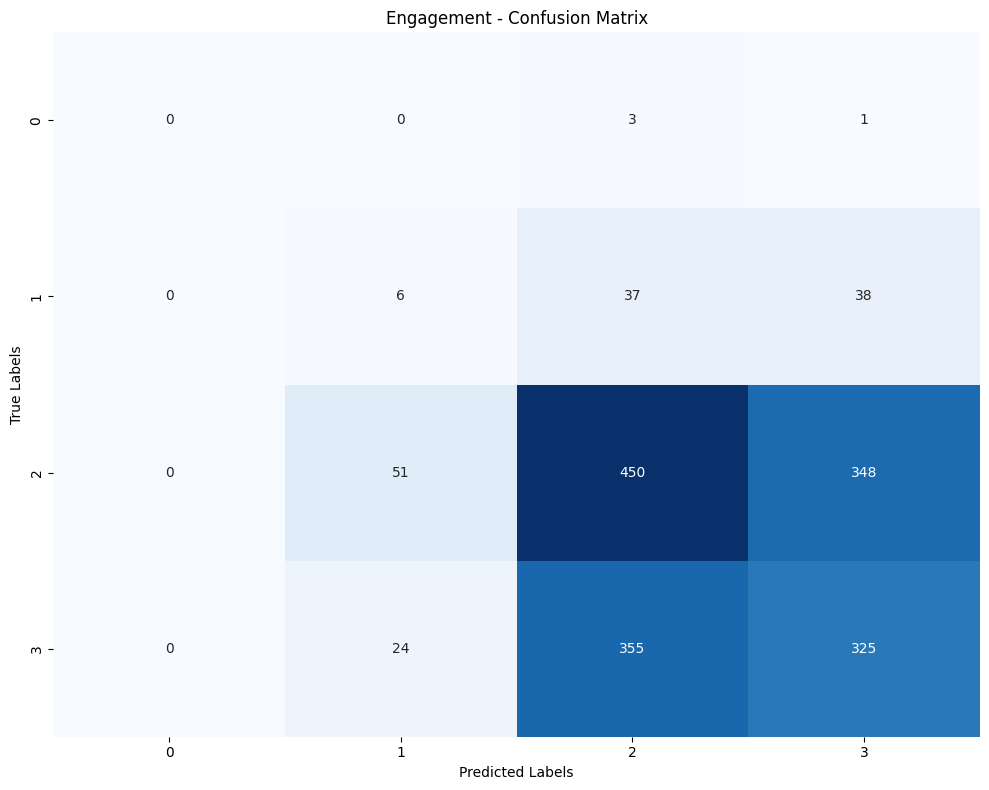

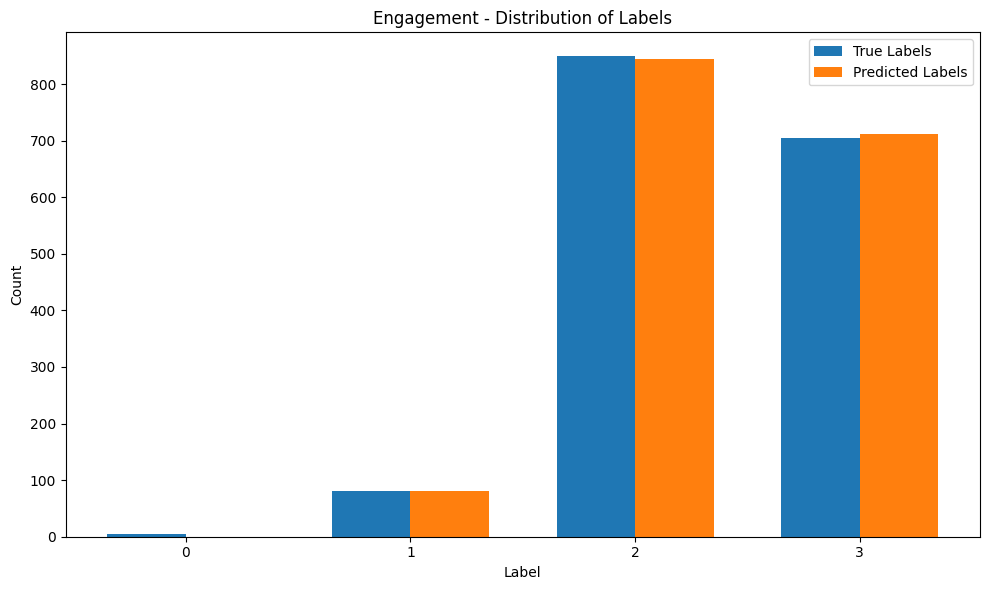

Classification report for Boredom:
              precision    recall  f1-score   support

           0       0.49      0.54      0.51       747
           1       0.34      0.30      0.32       519
           2       0.16      0.16      0.16       335
           3       0.03      0.03      0.03        37

    accuracy                           0.37      1638
   macro avg       0.26      0.26      0.26      1638
weighted avg       0.37      0.37      0.37      1638

Confusion Matrix:
[[404 177 153  13]
 [241 156 111  11]
 [168 107  53   7]
 [ 11  16   9   1]]


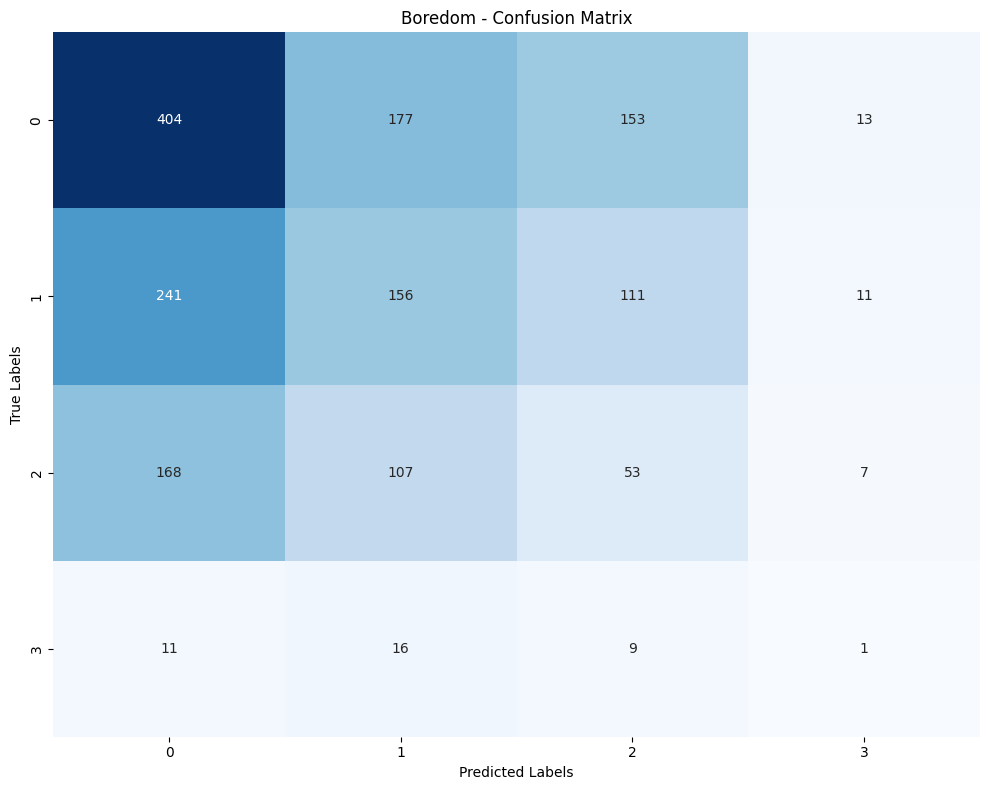

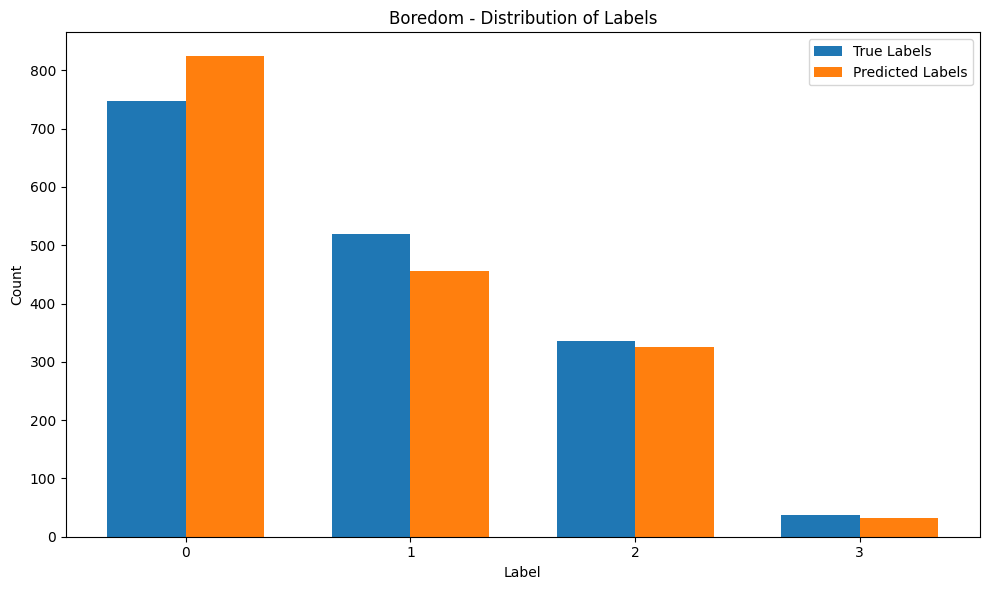

Classification report for Confusion:
              precision    recall  f1-score   support

           0       0.71      0.72      0.71      1135
           1       0.31      0.32      0.31       368
           2       0.08      0.07      0.07       116
           3       0.00      0.00      0.00        19

    accuracy                           0.57      1638
   macro avg       0.28      0.28      0.28      1638
weighted avg       0.57      0.57      0.57      1638

Confusion Matrix:
[[813 234  73  15]
 [234 117  16   1]
 [ 87  21   8   0]
 [ 14   4   1   0]]


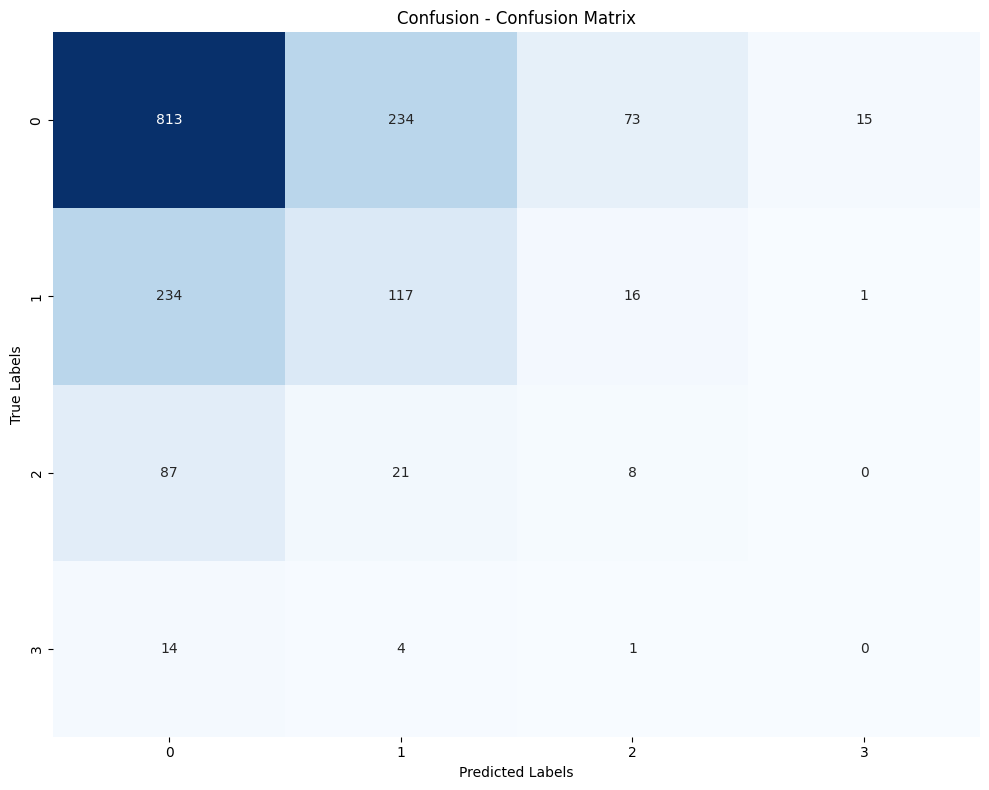

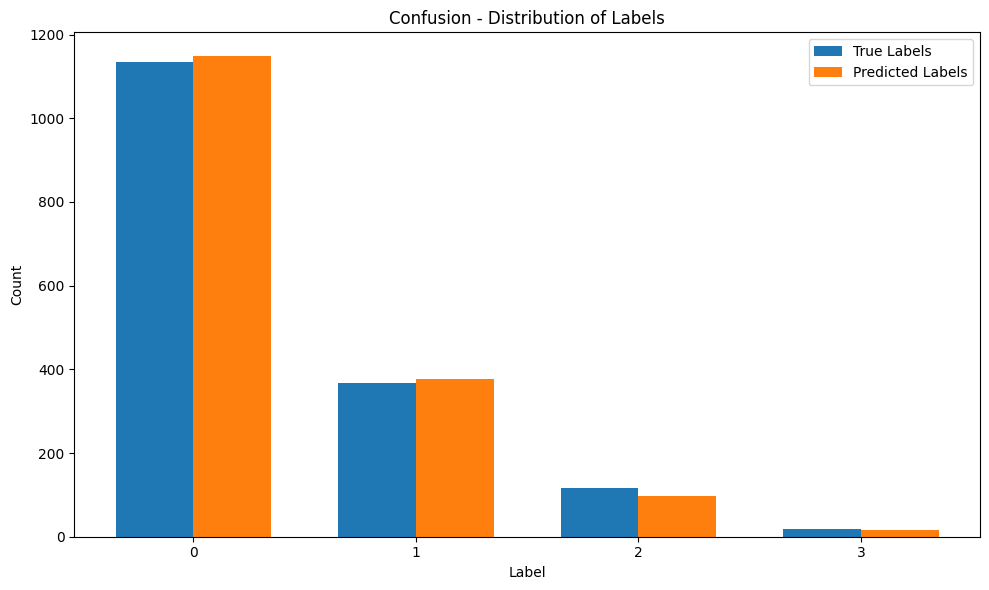

Classification report for Frustration:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80      1279
           1       0.17      0.13      0.15       280
           2       0.06      0.05      0.06        56
           3       0.00      0.00      0.00        23

    accuracy                           0.66      1638
   macro avg       0.25      0.25      0.25      1638
weighted avg       0.64      0.66      0.65      1638

Confusion Matrix:
[[1048  175   41   15]
 [ 238   37    4    1]
 [  45    8    3    0]
 [  19    3    1    0]]


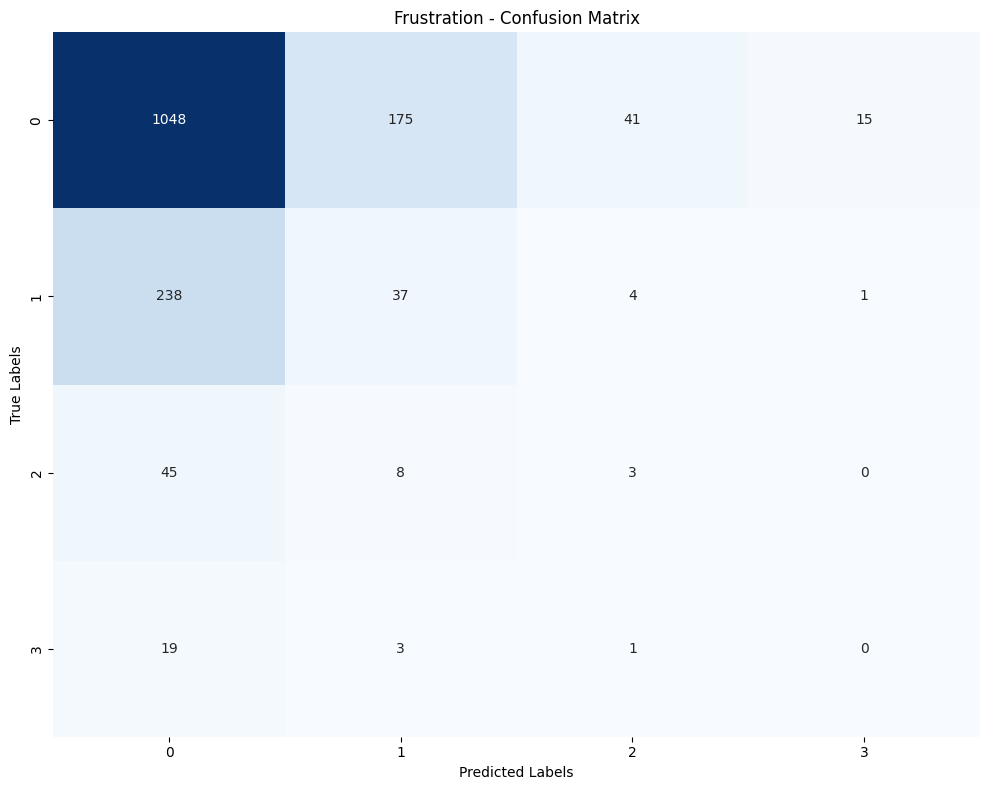

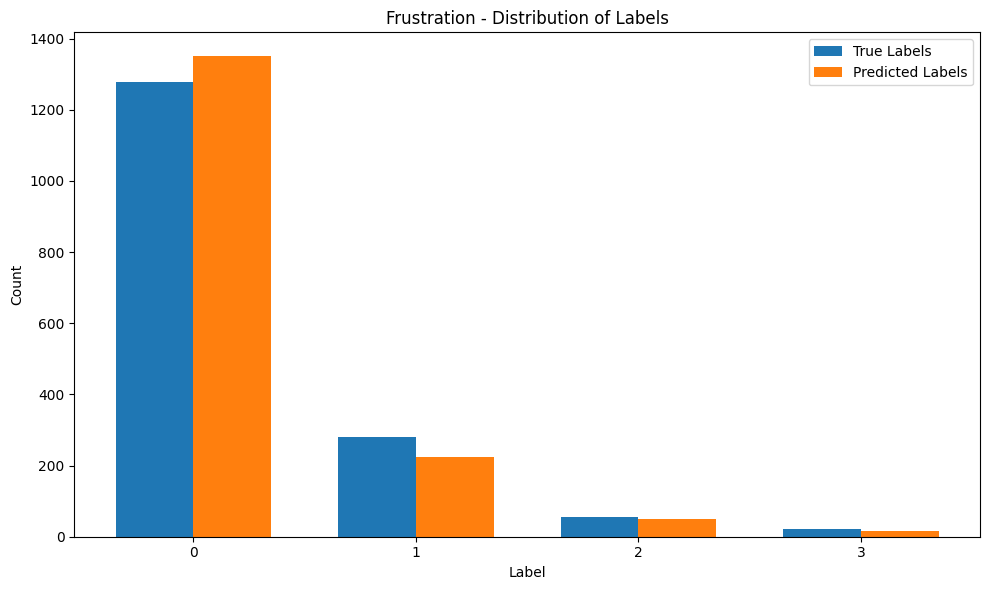


--- Evaluation Complete ---


In [3]:
# ------------------------------
# Main Execution
# ------------------------------
if __name__ == "__main__":
    torch.multiprocessing.set_start_method('spawn')
    
    # CSV file paths
    train_csv = LABELS_DIR / "TrainLabels.csv"
    val_csv = LABELS_DIR / "ValidationLabels.csv"
    test_csv = LABELS_DIR / "TestLabels.csv"
    
    # Precompute caches and LMDB for each resolution
    resolutions = [112, 224, 300]
    for csv in [train_csv, val_csv, test_csv]:
        for res in resolutions:
            precompute_best_frames(csv, FRAMES_DIR, num_frames=NUM_FRAMES, resolution=res)
            convert_pkl_to_lmdb(csv, num_frames=NUM_FRAMES, resolution=res,
                                transform=get_transform(res), lmdb_map_size=1 * 1024**3)
    
    # ------------------------------
    # Hyperparameter Tuning using Progressive Training over All 3 Resolutions
    # ------------------------------
    def objective(trial):
        torch.cuda.empty_cache()
        gc.collect()
        batch_size = trial.suggest_categorical("batch_size", [4, 6, 8])
        lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
        lstm_hidden = trial.suggest_categorical("lstm_hidden", [256, 384])
        lstm_layers = 2  # Fixed to 2 layers
        dropout_rate = trial.suggest_categorical("dropout_rate", [0.3, 0.4, 0.5])
        total_epochs = sum(eps for _, eps in PROG_SCHEDULE)
        
        current_res = PROG_SCHEDULE[0][0]  # First resolution
        current_batch_size = BATCH_SIZES[current_res]
        
        model = EfficientNetV2L_BiLSTM_CrossAttn_CBAM(
            lstm_hidden=lstm_hidden, 
            lstm_layers=lstm_layers,
            dropout_rate=dropout_rate, 
            classifier_hidden=256
        ).to(device)
        
        trial_checkpoint = MODEL_DIR / f"trial_eff_v2l_{trial.number}__bilstm_spatialcbam_checkpoint.pth"
        trial_checkpoint.parent.mkdir(parents=True, exist_ok=True)
        loss = progressive_train_model(
            model, 
            total_epochs, 
            lr, 
            trial_checkpoint, 
            current_batch_size,
            patience=3, 
            gradient_accum_steps=GRADIENT_ACCUM_STEPS
        )
        del model
        torch.cuda.empty_cache()
        gc.collect()
        return loss
    
    db_path = BASE_DIR / "notebooks" / "tuning_eff_v2l_bilstm_spatialcbam_optim.db"
    db_path.parent.mkdir(parents=True, exist_ok=True)
    try:
        conn = sqlite3.connect(db_path)
        print(f"Database created/connected at: {db_path}")
        conn.close()
    except Exception as e:
        print(f"DB Error: {e}")
    study = optuna.create_study(
        direction="minimize",
        pruner=MedianPruner(n_startup_trials=2, n_warmup_steps=10),
        study_name="efficientnetv2l_bilstm_spatialcbam_study",
        storage=f"sqlite:///{db_path}",
        load_if_exists=True
    )
    target_trials = 30
    while True:
        successes = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE and np.isfinite(t.value)]
        remaining = target_trials - len(successes)
        if remaining <= 0:
            break
        print(f"Running {remaining} additional trial(s) to reach {target_trials} successful trials...")
        study.optimize(objective, n_trials=remaining, catch=(Exception,))
    print(f"Optuna tuning complete. Total successful trials: {len(successes)}")
    best_trial = min(successes, key=lambda t: t.value) if successes else optuna.trial.FrozenTrial(
        number=0,
        state=optuna.trial.TrialState.COMPLETE,
        value=float('inf'),
        datetime_start=datetime.datetime.now(),
        datetime_complete=datetime.datetime.now(),
        params={
            "batch_size": 8,
            "lr": 1e-4,
            "lstm_hidden": 256,
            "dropout_rate": 0.5
        },
        distributions={},
        user_attrs={},
        system_attrs={},
        intermediate_values={}
    )
    print(f"Best trial parameters: {best_trial.params}")
    
    # -----------------------------------------------------
    # Final Training
    # -----------------------------------------------------
    total_epochs = sum(eps for _, eps in PROG_SCHEDULE)
    final_checkpoint = MODEL_DIR / "final_model_eff_v2l_bilstm_spatialcbam_checkpoint.pth"  # Updated name
    if not final_checkpoint.exists():
        print("\n--- Starting Final Training ---")
        params = best_trial.params
        batch_size = params.get("batch_size", 4)
        lr = params.get("lr", 1e-4)
        lstm_hidden = params.get("lstm_hidden", 256)
        lstm_layers = 2  # Force 2 layers for BiLSTM
        dropout_rate = params.get("dropout_rate", 0.5)
        final_model = EfficientNetV2L_BiLSTM_CrossAttn_CBAM(
            lstm_hidden=lstm_hidden, 
            lstm_layers=lstm_layers,
            dropout_rate=dropout_rate, 
            classifier_hidden=256
        ).to(device)
        
        # Unfreeze backbone layers for fine-tuning
        if hasattr(final_model.backbone, "blocks"):
            for i, block in enumerate(final_model.backbone.blocks):
                if i >= 6:
                    for param in block.parameters():
                        param.requires_grad = True
                        
        final_checkpoint.parent.mkdir(parents=True, exist_ok=True)
        final_loss = progressive_train_model(
            final_model, 
            total_epochs, 
            lr, 
            final_checkpoint, 
            batch_size,
            patience=5, 
            gradient_accum_steps=GRADIENT_ACCUM_STEPS
        )
    
    # -----------------------------------------------------
    # Evaluation on Test Set 
    # -----------------------------------------------------
    test_transform = get_transform(300)  # Highest resolution
    test_set = VideoDatasetRaw(test_csv, FRAMES_DIR, num_frames=NUM_FRAMES, transform=test_transform)
    test_loader = DataLoader(test_set, batch_size=4, shuffle=False, num_workers=0, pin_memory=True)

    eval_model = EfficientNetV2L_BiLSTM_CrossAttn_CBAM(
        lstm_hidden=best_trial.params.get("lstm_hidden", 256),
        lstm_layers=2,  # Force 2-layer BiLSTM
        dropout_rate=best_trial.params.get("dropout_rate", 0.5),
        classifier_hidden=256
    ).to(device)

    state = torch.load(final_checkpoint, map_location=device)
    eval_model.load_state_dict(state["model_state_dict"])
    eval_model.to(device)
    evaluate_model(eval_model, test_loader)
    torch.cuda.empty_cache()
    gc.collect()
    print("\n--- Evaluation Complete ---")